# 5.2 Contour-based techniques for image segmentation

In the previous chapter we had fun with region based techniques for image segmentation, where the resulting segments cover the entire image. In this want we are going to experience **contour-based techniques**, whose are based on detecting specific contours in the image (e.g. circles). In this context, image contours are defined as edge pixels that enclose a region.  

Contour-based techniques could be roughly classified into:
- **Local tecniques.**
   - LoG + zero crossing.
   - Edge following (Canny operator).
- **Global techniques.**
   - Hough transform. 
   
This notebook will cover the **Hough transform** (section 5.2.1), a contour-based technique that can be used for detecting regions with an arbitrary shape in images.

## Problem context - Self-driving car 

A prestigious company located at PTA (The Andalusia Technology Park) is organizing a [hackathon](https://en.wikipedia.org/wiki/Hackathon) for this year in order to motivate college students to make further progress in the autonomous cars field. Computer vision students in UMA decided to take part in it, but the organizers have posed an initial basic task to guarantee that participants have expertise in image processing techniques. 

This way, the company sent to students a task for **implementing a basic detector road lane lines using OpenCV in python**. We are lucky! These are two tools that we know well ;).

Detecting lines in a lane is a fundamental task for autonomous vehicles while driving on the road. It is the building block to other path planning and control actions like breaking and steering. 

So here we are! We are going to detect road lane lines using Hough transform in OpenCV.$\\[5pt]$ 

<img src="./images/car.gif" width="400" align="center">$\\[10pt]$

In [1]:
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats as stats

matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
images_path = './images/'

## 5.2.1 Hough transform

The **Hough Transform** if a technique for the detection of arbitrary shapes in an image. For that, such shapes must be expressed in an analytical form (**classic Hough**), e.g. lines, circles, ellipses, etc., or in a numerical form (**generalized Hough**) where the shape is given by a table. Since our goal is to detect lines, we will focus here on analytically expressed shapes. 

Specifically, a line can be represented analytically as:

$$y = mx + n$$

or in its parametric form, as:

$$\rho = x \cos \theta + y \sin \theta$$

where $\rho$ is the perpendicular distance from the origin $(0,0)$ to the line, and $\theta$ is the angle formed by this perpendicular line and horizontal axis measured in counter-clockwise. Thereby, we are going to represent lines using the pair of parameters $(\rho, \theta)$.

<img src="./images/houghlines.svg" width="250"/>$\\[5pt]$

The Hough transform works by a voting procedure, which is carried out in a parameter space ($\rho,\theta$ in our case). It works as follows:

1. **Build an accumulator matrix**, where rows index the possible values of $\rho$, and columns those for $\theta$. *For example, if the possible values for $\rho$ are $0, 1, 2, \ldots d$ (where $d$ is the max distance e.g. diagonal size of the image) and those for $\theta$ are $0, 1, 2 \ldots 179$, the matrix shape would be $(d,180)$.*
2. **Binarize the input image** to obtain pixels that are candidates to belong to the shape contours (e.g. by applying an edge detector).
3. For each candidate (white pixel):
   1. **Evaluate**: Since the point coordinates $(x,y)$ are known, place them in the line parametric form and iterate over the possible values of $\theta$ to obtain the values for $\rho$. In the previous example $\rho_i = x \cos \theta_i + y \sin \theta_i, \forall i\in[0,180]$
   2. **Vote**: For every obtained pair $(\rho_i, \theta_i)$ increment by one the value of its associated cell in the accumulator.
4. Finally, **obtain the shape candidates** by setting a threshold to control how many votes needs a pair $(\rho, \theta)$  to be considered a line, and by applying local maxima in the accumulator space. $\\[10pt]$
  
<img src="./images/houghlinesdemo.gif" width="400" align="center">$\\[2pt]$
<center><i>Left, image space. Right, parameter space illustrating the evoluation of the votes. Note that in this example $\theta$ have only 8 possible values.</i></center>

The idea behind this algorithm is that when a pixel in the image space votes for all the lines that go through it in the parameter space, when a second pixel belonging to the same line votes, then the line connecting both pixels would have two votes. 

#### <font color="orange">OpenCV pill</font>
    
OpenCV implements the method [`cv2.HoughLines()`](https://docs.opencv.org/4.2.0/dd/d1a/group__imgproc__feature.html#ga46b4e588934f6c8dfd509cc6e0e4545a) for detecting lines using the Hough transform. However, prior to its usage, and as commented in the `step 1.` of the algorithm, it is needed a binary image. For that we are going to resort to our old friend the Canny algorithm, so the detected edges will be the white pixes in the binary image.

As we now, noisy images seriously hamper the performance of computer vision techniques, and since [cv2.Canny](https://docs.opencv.org/4.2.0/dd/d1a/group__imgproc__feature.html#ga04723e007ed888ddf11d9ba04e2232de) does not include blurring, we provide here a method called `gaussian_smoothing()` to assist you.

In [2]:
def gaussian_smoothing(image, sigma, w_kernel):
    """ Blur and normalize input image.   
    
        Args:
            image: Input image to be binarized
            sigma: Standard deviation of the Gaussian distribution
            w_kernel: Kernel aperture size
                    
        Returns: 
            binarized: Blurred image
    """   
    
    # Define 1D kernel
    s=sigma
    w=w_kernel
    kernel_1D = [np.exp(-z*z/(2*s*s))/np.sqrt(2*np.pi*s*s) for z in range(-w,w+1)]
    
    # Apply distributive property of convolution
    kernel_2D = np.outer(kernel_1D,kernel_1D)
    
    # Blur image
    smoothed_img = cv2.filter2D(image,cv2.CV_8U,kernel_2D)
    
    # Normalize to [0 254] values
    smoothed_norm = np.array(image.shape)
    smoothed_norm = cv2.normalize(smoothed_img,None, 0, 255, cv2.NORM_MINMAX)
    
    return smoothed_norm

### **<span style="color:green"><b><i>ASSIGNMENT 1: Detecting lines with Hough</i></b></span>**

**Your first task is** to apply [`cv2.HoughLines()`](https://docs.opencv.org/4.2.0/dd/d1a/group__imgproc__feature.html#ga46b4e588934f6c8dfd509cc6e0e4545a) to the image `car.png`, a test image taken from the frontal camera of a car. Draw the resultant lines using [`cv2.line()`](https://docs.opencv.org/4.2.0/d6/d6e/group__imgproc__draw.html#ga7078a9fae8c7e7d13d24dac2520ae4a2).

The main inputs of `cv2.HoughLines()` are:

- image: binary input image
- rho: distance resolution of the accumulator in pixels (usually 1, it may be bigger for high resolution images) 
- theta: angle resolution of the accumulator in radians. (usually $\frac{\pi}{180}$)$\\[2pt]$
- threshold: only line candidates having a number of votes $>$ threshold are returned.

And it returns:
- a  $( n\_lines x 2 )$ array containing, in each row, the parameters of each detected line.

*Note that, for drawing the lines, you have to [transform the resultant lines](https://answers.opencv.org/question/21132/draw-the-lines-detected-by-cvhoughlines/) from the $(\rho, \theta)$ space to Cartesian coordinates.*

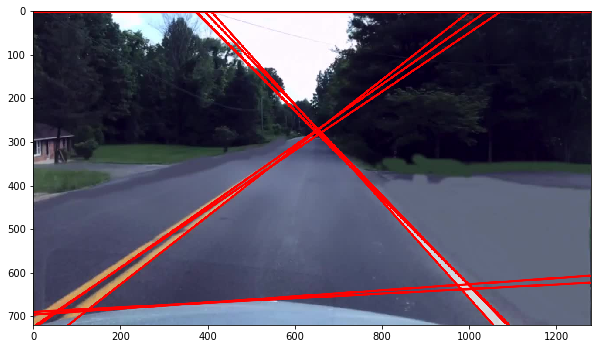

In [3]:
# Assignment 1
# Read the image
image = cv2.imread(images_path + "car.png",-1)

# Convert to RGB and get gray image
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Blur the gray image
gray = gaussian_smoothing(gray,2,5)

# Apply Canny algorithm
edges = cv2.Canny(gray,100,200,apertureSize = 3)

# Search for lines using Hough transform
lines = cv2.HoughLines(edges, rho=1, theta=np.pi / 180, threshold=150)

# For each line
for i in range(0, len(lines)):
    
    # Transform from polar coordinates to cartesian coordinates
    rho = lines[i][0][0]
    theta = lines[i][0][1]
    
    a = math.cos(theta)
    b = math.sin(theta)
    
    x0 = a * rho
    y0 = b * rho
    
    # Get two points in that line 
    pt1 = (int(x0 + 2000*(-b)), int(y0 + 2000*(a)))
    pt2 = (int(x0 - 2000*(-b)), int(y0 - 2000*(a)))
    
    # Draw the line in the RGB image
    cv2.line(image, pt1, pt2, (255,0,0), 3, cv2.LINE_AA)

# Show resultant image
plt.imshow(image)

### 5.1.2.1 Probabilistic Hough transform

For high-resolution images and large accumulator sizes the Hough transform may need long execution times. However, in applications like autonomous cars a fast execution is mandatory. For example, having a car moving at 100km/h covers $\sim28$ meters in a second. Imagine how much lines can change in that time!

#### <font color="orange">OpenCV pill</font>
    
OpenCV provides with the method [`cv2.HoughLinesP()`](https://docs.opencv.org/4.2.0/dd/d1a/group__imgproc__feature.html#ga8618180a5948286384e3b7ca02f6feeb) a more complex implementation of the Hough Line Transform, which is called **probabilistic Hough Transform**. This alternative doesn’t take all the points into account, but a random subset of them that are still enough for line detection. This also results in smaller thresholds when deciding if a line exists or not.  

### **<span style="color:green"><b><i>ASSIGNMENT 2: Another option for detecting lines</i></b></span>**

Apply [`cv2.HoughLinesP()`](https://docs.opencv.org/4.2.0/dd/d1a/group__imgproc__feature.html#ga8618180a5948286384e3b7ca02f6feeb) to the image `car.png` and draw the detected lines.

This function returns:
- line segments $((x1,y1),(x2,y2))$ instead of the line equation parameters.

For that, two additional arguments are needed:
- minLineLength: line segments shorter than that are rejected. 
- maxLineGap: maximum allowed gap between points on the same line to link them.

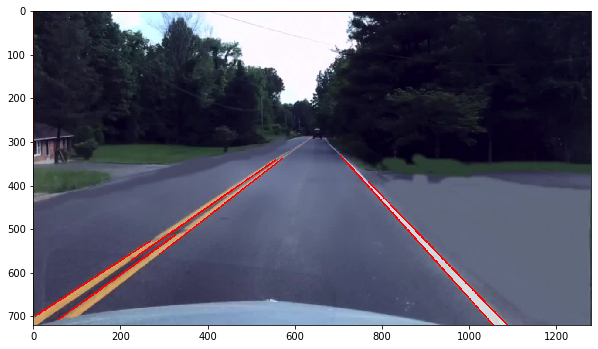

In [4]:
# Assigment 2
# Read the image
image = cv2.imread(images_path + "car.png",-1)

# Convert to RGB and get gray image
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Blur the gray image
gray = gaussian_smoothing(gray,1,2)

# Apply Canny algorithm
edges = cv2.Canny(gray,100,200,apertureSize = 3)

# Search for lines using probabilistic Hough transform
lines = cv2.HoughLinesP(edges,1,np.pi/180,100,minLineLength=200,maxLineGap=15)

# For each line
for line in lines:
    
    # Draw the line in RGB image
    x1,y1,x2,y2 = line[0]
    cv2.line(image,(x1,y1),(x2,y2),(255,0,0),2)

# Show resultant image
plt.imshow(image)

## Conclusion

Terrific work! In the road lane lines detection context you have learned:
- to detect shapes in images using Hough transform .

Also, you obtained some knowledge about: 

- self-driving cars and computer vision, and
- lane line detection for autonomous cars.

See you in the next one! Keep learning!
